In [ ]:
#The code below is the implementation of logistic classfication
# We also print the training, testing accuracy and AUC value
# the last output is the coefficients of BERT, SVM and Length because the function is Y=a*w1+b*w2+c*w3

In [11]:
import pandas as pd
def logistic_classification(): 
    X_train=pd.read_csv('train_modified.csv')
    Y_train=pd.read_csv('train_c.csv')
    X_test=pd.read_csv('test_modified.csv')
    Y_test=pd.read_csv('test_c.csv')
    classifier = LogisticRegression()
    clf=classifier.fit(X_train,Y_train)
    train_accuracy = clf.score(X_train, Y_train)
    print('\nTraining:')
    print(' accuracy:',format( 100*train_accuracy , '.2f') ) 
    
    print('\nTesting: ')
    test_predictions = clf.predict(X_test)
    test_accuracy = clf.score(X_test, Y_test)
    print(' accuracy:', format( 100*test_accuracy , '.2f') )
    
    class_probabilities = clf.decision_function(X_test)
    test_auc_score = sklearn.metrics.roc_auc_score(Y_test, class_probabilities)
    print(' AUC value:', format( 100*test_auc_score , '.2f') )
    bes=clf.coef_
    print("BERT                SVM               LEN")
    print(bes)

In [95]:
logistic_classification()


Training:
 accuracy: 99.91

Testing: 
 accuracy: 96.36
 AUC value: 99.37
BERT                SVM               LEN
[[ 0.86245493  2.25609201 -0.08396549]]


/Users/lu/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [ ]:
#The code below aims to calculate each news and try to find why the model decide whether it is real or fake
#The funciton is Y=a*BERT+b*SVM+c*Length and we have know the coefficients from above
#We just calculate the function again to get the absolute value of each term 
#The term with largest absolute value impacts result most.
# The output below means 2094 news are decided mainly by Bert, 46 are decided by svm and none of them are decided by length

In [142]:
import csv
bert=0.86245493
svm=2.25609201
length=-0.08396549
max_w=[]
bn=0
sn=0
ln=0
with open('test_modified.csv','r') as csvfile:
    reader = csv.reader(csvfile)
    for i,rows in enumerate(reader):
        if i > 0:
            w1=abs(bert*float(rows[0]))
            w2=abs(svm*float(rows[1]))
            w3=abs(length*float(rows[2]))
            x=max(w1, w2, w3)
            if(x==w1):
                bn+=1
                max_w.append("bert")
            if(x==w2):
                sn+=1
                max_w.append("svm")
            if(x==w3):
                ln+=1
                max_w.append("length")
print(bn, sn, ln)

2094 46 0


In [ ]:
#The two functions below was rewritten according to the new dataset
#In these two functions, we delete some unimportant words in news like "reuters" and some words with encoding problems like "ä"

In [39]:
def clean_text(string):
    stops=set()
    text = string.lower().split()
    text = " ".join(text)
    text = re.sub(r"http(\S)+", ' ', text)
    text = re.sub(r"www(\S)+", ' ', text)
    text = re.sub(r"&", ' and ', text)
    text = re.sub(" - ", "", text)
    # text = re.sub(r"[^0-9a-zA-Z]+", ' ', text) todo maybe should not add this line it will dramatically decrease the auc score
    text = text.split("(reuters) - ")[-1].split("reuters")[-1]
    text = text.split()
    text = [w for w in text if "ä" not in stops]
    text = [w for w in text if w not in stops]
    text = " ".join(text)
    return text


def extract_data_from_file(filename, upper = 100,lower = 0, index=None):
    data = pd.read_excel(filename)
    string_list = list()
    output = list()
    i=0
    if index == None:
        for text, label in zip(data["tweet"], data["label"]):
            if (label != 0 or label != 1) and type(text) != str:
                pass
            else:
                if (upper >=len(text.split()) >= lower):
                    string_list.append(clean_text(text))
                    if label == 1 or label =="fake":
                        output.append(0)
                    else:
                        output.append(1)
    stops = set(stopwords.words("english"))
    for text in string_list:
        text = text.split()
        text = [w for w in text if w not in stops]
        text = " ".join(text)
        string_list[i]=text
        i=i+1
    return string_list, output

In [ ]:
#The code below extract data from file and use function train_test_split to split data into X_train, X_test, Y_train, Y_test

In [ ]:
from sklearn.model_selection import train_test_split
X, Y=extract_data_from_file("train.xlsx")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=1)

In [ ]:
#This is the latest version trianing and predicting on new data

In [11]:
import nltk
import csv
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn

# import warnings filter
from warnings import simplefilter

# ignore all future warnings
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

from sklearn import linear_model
from sklearn import metrics

import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import *
import pandas as pd

import re
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from nltk import word_tokenize
import torch.nn as nn
import torch
from sklearn.metrics import roc_auc_score
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import torch.optim as optim

# LSTM
from keras.preprocessing.text import Tokenizer
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

import os
os.getcwd()

# Create a bag of words (BOW) representation from text documents, using the Vectorizer function in scikit-learn
#
# The inputs are
#  - a filename containing the news in xlsx format
#  - we label all news with label == 'real' as "1"
#  - we label all news with label == 'fake' as "0"
#  - this creates a simple set of labels for binary classification
#
#  The function extracts the text and labels for each news from the xlsx data
#  It then tokenizes and creates a sparse bag-of-words array using scikit-learn vectorizer function
#  The number of rows in the array is the number of news with label 'real' or 'fake'
#  The number of columns in the array is the number of terms in the vocabulary
simplefilter(action='ignore', category=FutureWarning)
stops = set(stopwords.words("english"))



# https://github.com/parthpatwa/covid19-fake-news-detection/blob/main/ml_baseline.ipynb

def clean_text(string):
    stops=set()
    text = string.lower().split()
    text = " ".join(text)
    text = re.sub(r"http(\S)+", ' ', text)
    text = re.sub(r"www(\S)+", ' ', text)
    text = re.sub(r"&", ' and ', text)
    # text = re.sub(r"[^0-9a-zA-Z]+", ' ', text) todo maybe should not add this line it will dramatically decrease the auc score
    text = text.split("(reuters) - ")[-1].split("reuters")[-1]
    text = text.split()
    text = [w for w in text if "ä" not in stops]
    text = [w for w in text if w not in stops]
    text = " ".join(text)
    return text


def extract_data_from_file(filename, upper = 500,lower = 300, index=None):
    data = pd.read_excel(filename)
    string_list = list()
    output = list()
    i=0
    if index == None:
        for text, label in zip(data["tweet"], data["label"]):
            if (label != 0 or label != 1) and type(text) != str:
                pass
            else:
                if (upper >=len(text.split()) >= lower):
                    string_list.append(clean_text(text))
                    if label == 1 or label =="fake":
                        output.append(0)
                    else:
                        output.append(1)
    print(len(string_list))
    stops = set(stopwords.words("english"))
    for text in string_list:
        text = text.split()
        text = [w for w in text if "ä" not in stops]
        text = [w for w in text if w not in stops]
        text = " ".join(text)
        string_list[i]=text
        i=i+1
    print(len(string_list))
    return string_list, output


def plot_matrix(intersection_matrix):
    fig, ax = plt.subplots()

    min_val, max_val = 0, 2

    ax.matshow(intersection_matrix, cmap=plt.cm.Blues)

    for i in range(2):
        for j in range(2):
            c = intersection_matrix[i, j]
            ax.text(j, i, str(c), va='center', ha='center')


def create_bow_from_news(filename):
    data = pd.read_excel(filename)
    print('Brief information of extracted data:')
    data.info()
    print()
    data['tweet'] = data['tweet'].map(lambda x: clean_text(x))

    print('Extracting tokens from each news.....(can be slow for a large number of news)......')

    text = [news for news in data["tweet"]]
    Y = [1 if element == "real" else 0 for element in data["label"]]

    vectorizer = CountVectorizer(stop_words='english', min_df=0.01, ngram_range=(1, 2))
    X = vectorizer.fit_transform(text)
    print('Data shape: ', X.shape)

    return X, Y, vectorizer


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()  # use sigmoid as a output layer here since we are using BCEloss

        # Put the declaration of the RNN network here

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

    def forward(self, init_input, hidden):
        combined = torch.cat((init_input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.sigmoid(output)
        return output, hidden


class word2VecRNN:  # Better
    def __init__(self, train_file: str = "Constraint_English_Train.xlsx",
                 test_file: str = "Constraint_English_Val.xlsx", input_size=120, hidden_size=150, output_size=2):
        # Extract basic Data
#         X_train, Y_train = extract_data_from_file(train_file)
#         X_test, Y_test = extract_data_from_file(test_file)
        X, Y=extract_data_from_file("train.xlsx")
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y)  
#         X_train1, Y_train1 = extract_data_from_file("Constraint_English_Train.xlsx")
#         X_train2, Y_train2 = extract_data_from_file("Constraint_English_Val.xlsx")
#         X_train = X_train1 + X_train2
#         Y_train = Y_train1 + Y_train2
#         X_test, Y_test = extract_data_from_file("english_test_with_labels.xlsx")
        # tokenize word
        X_train = [word_tokenize(sentence) for sentence in X_train]
        X_test = [word_tokenize(sentence) for sentence in X_test]
        # eliminate stopwords
        common_stop_words = set(stops)
        edited_stop_words = set()  # todo edit it in the future
        self.stop_words = common_stop_words.union(edited_stop_words)  # edit it in the future
        self.X_train = [[word for word in sentence_list if word not in self.stop_words] for sentence_list in X_train]
        self.X_test = [[word for word in sentence_list if word not in self.stop_words] for sentence_list in X_test]

        # edit basic Y, Y_train = [torch.tensor[Fake, Real]]
        self.Y_train = [torch.tensor([[0.0, 1.0]]) if element == 1 else torch.tensor([[1.0, 0.0]]) for element in
                        Y_train]
        self.Y_test = [torch.tensor([[0.0, 1.0]]) if element == 1 else torch.tensor([[1.0, 0.0]]) for element in Y_test]

        # build word embedding model
        X_all = self.X_train + self.X_test
        self.model = Word2Vec(X_all, min_count=1, size=input_size)  # we may change size here
        # save model
        self.model.save('model.bin')
        # createRNN
        self.RNN_model = RNN(input_size, hidden_size, output_size)
        # optimizer
        #self.optimizer = optim.Adam(self.RNN_model.parameters(), lr=0.00009)
        self.optimizer = torch.optim.Adagrad(self.RNN_model.parameters(), lr=0.002)
        #self.optimizer = optim.RMSprop(self.RNN_model.parameters(),alpha=0.95, lr=0.0001)

    def train_iteration_word_rnn(self, learning_rate, category_tensor, sentenceList):
        criterion = nn.BCELoss()  # todo need to check whether need softmax layer
        hidden = self.RNN_model.init_hidden()  # first initial is hidden
        self.RNN_model.zero_grad()  # initialize gradient

        # The forward process
        output = 0
        for word in sentenceList:
            temp = self.model.wv.__getitem__(word)
            output, hidden = self.RNN_model(torch.reshape(torch.from_numpy(temp), [1, -1]), hidden)

        # change some format
        category_tensor = torch.reshape(category_tensor, [1, 2])

        # The backward process
        loss = criterion(output, category_tensor)
        loss.backward()
        self.optimizer.step()  # Does the update

        # Add parameters' gradients to their values, multiplied by learning rate
        # for p in self.RNN_model.parameters():
        #   p.data.add_(p.grad.data, alpha=-learning_rate)  # todo maybe could use quasi Newton in the future

        return output, loss.item()

    def train(self, learning_rate, n_iters=6):
        current_loss = 0
        print_every = 1000
        count = 0
        for iter in range(1, n_iters + 1):  # iteration
            for sentence_list, category_tensor in zip(self.X_train, self.Y_train):
                output, loss = self.train_iteration_word_rnn(learning_rate, category_tensor, sentence_list)
                current_loss += loss
                count += 1

                if count % print_every == 0:  # print loss
                    print('Average loss: %.4f' % (current_loss / print_every))
                    current_loss = 0

        torch.save(self.RNN_model, 'word-rnn-classification.pt')  # todo Confused

    def predict(self, string):
        sentenceList = word_tokenize(string)
        sentenceList = [word for word in sentenceList if word not in self.stop_words]
        hidden = self.RNN_model.init_hidden()  # first initial is hidden
        self.RNN_model.zero_grad()  # initialize gradient

        # The forward process
        output = 0
        for word in sentenceList:
            output, hidden = self.RNN_model(torch.reshape(torch.from_numpy(self.model.wv.__getitem__(word)), [1, -1]),
                                            hidden)
        # print format
        print("{0}'s real news faked rate {1}".format(string, float(output[0, 1].detach())))
        return output

    def get_predicted_possibility_list(self):
        outputList = []
        Y_list = []
        for sentenceList in self.X_test: #X_train
            hidden = self.RNN_model.init_hidden()
            self.RNN_model.zero_grad()
            output = 0
            for word in sentenceList:
                output, hidden = self.RNN_model(
                    torch.reshape(torch.from_numpy(self.model.wv.__getitem__(word)), [1, -1]), hidden)
            outputList.append(float(output[0, 1].detach()))

        Y_list = [int(element[0, 1]) for element in self.Y_test]#self.Y_train

        return outputList, Y_list

    def accuracy(self):
        output_list, Y_list = self.get_predicted_possibility_list()
#         data = pd.read_excel("english_test_with_labels.xlsx")
#         model_save_name = "Wrong_data_RNN.csv"
#         wrong_list=[]
        k = 0
        matrix = np.zeros((2, 2))
        for c, v in zip(Y_list, output_list):
            if int(c) == 1:
                if v >= 0.5:
                    matrix[1, 1] += 1
                else:
                    matrix[1, 0] += 1
#                     wrong_list.append(k)
            else:
                if v <= 0.5:
                    matrix[0, 0] += 1
                else:
                    matrix[0, 1] += 1
        plot_matrix(matrix)
        return matrix

    def eval_auc(self):
        Y_list, outputList = self.get_predicted_possibility_list()
        return roc_auc_score(Y_list, outputList)


class BoWsvm:
    def __init__(self, train_file: str = "Constraint_English_Train.xlsx",
                 test_file: str = "Constraint_English_Val.xlsx"):
        # Extract basic Data
#         self.X_train, self.Y_train = extract_data_from_file(train_file)
#         self.X_test, self.Y_test = extract_data_from_file(test_file)
#         X_train1, Y_train1 = extract_data_from_file("Constraint_English_Train.xlsx")
#         X_train2, Y_train2 = extract_data_from_file("Constraint_English_Val.xlsx")
        X, Y=extract_data_from_file("train.xlsx")
        self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(X, Y, test_size=0.7,random_state=1)
        print(len(self.X_test))

        self.pipeline = Pipeline([
            ('bow', CountVectorizer()), #todo may try other paramethers here
            #("svm_clf", SVC(kernel="sigmoid", gamma=5, C=0.001)),
            ('tfidf', TfidfTransformer()), #todo may use other transformer here
            ('c', LinearSVC()) # todo can use other svc model
        ])
        self.pipeline.fit(self.X_train, self.Y_train)



    def test(self):
        return roc_auc_score(self.Y_test, self.pipeline.predict(self.X_test))
    def accuracy(self):
        output_list = self.pipeline.predict(self.X_test)
#         data = pd.read_excel("english_test_with_labels.xlsx")
#         model_save_name = "Wrong_data_SVM.csv"
#         wrong_list=[]
        k = 0
        matrix = np.zeros((2, 2))
        for c, v in zip(self.Y_test, output_list):
            if int(c) == 1:
                if v >= 0.5:
                    matrix[1, 1] += 1
                else:
                    matrix[1, 0] += 1
#                     wrong_list.append(k)
            else:
                if v <= 0.5:
                    matrix[0, 0] += 1
                else:
                    matrix[0, 1] += 1
#                     wrong_list.append(k)
            k=k+1
        plot_matrix(matrix)
#         df = data.iloc[wrong_list]
#         df.to_csv(model_save_name, encoding="utf-8")
        return matrix


class LSTMModel(nn.Module):
    def __init__(self, ntoken=2, ninp=100, nhid=256, nlayers=1, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.drop = nn.Dropout(dropout)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.rnn = nn.LSTM(ninp, nhid, nlayers, dropout=dropout)
        self.decoder = nn.Linear(nhid, ntoken)

        self.init_weights()

        self.nhid = nhid
        self.nlayers = nlayers

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, input, hidden):
        emb = self.drop(self.encoder(input))
        output, hidden = self.rnn(emb, hidden)
        output = self.drop(output)
        decoded = self.decoder(output)
        return decoded, hidden

    def init_hidden(self, bsz):
        weight = next(self.parameters())
        return (weight.new_zeros(self.nlayers, bsz, self.nhid),
                weight.new_zeros(self.nlayers, bsz, self.nhid))


def myLSTM():
    X, Y=extract_data_from_file("train.xlsx")
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y,random_state=1)
#     X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=1)
    X_all = X_train + X_test
    
    max_len = 100
#     for sentence in X_all:
#         new_len = len(sentence.split())
#         if new_len > max_len:
#             max_len = new_len
#     max_len += 5
    vocabulary_size = 1000 #todo test this size
    tokenizer = Tokenizer(num_words=vocabulary_size)
    tokenizer.fit_on_texts(X_all)
    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)

    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    max_review_length = max_len
    X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
    X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

    embedding_vector_length =100 #todo change this length
    model = Sequential()
    model.add(Embedding(vocabulary_size, embedding_vector_length, input_length=max_review_length))
    model.add(LSTM(40)) #todo change the parameter here
    model.add(Dense(1, activation='sigmoid')) #todo need to test, activiation
    model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])#todo change optimizer
    print(model.summary())
    history=model.fit(X_train, Y_train, epochs=2, batch_size=64,validation_data=(X_test, Y_test)) #todo change epochs, batchsize
    # Final evaluation of the model
    scores = model.evaluate(X_test, Y_test, verbose=0)
    
    output_l= model.predict(X_test)
    #data = pd.read_excel("english_test_with_labels.xlsx")
#     model_save_name = "Wrong_data_LSTM.csv"
#     wrong_list=[]
    k = 0
    matrix = np.zeros((2, 2))
    for c, v in zip(Y_test, output_l):
        if int(c) == 1:
            if v >= 0.5:
                matrix[1, 1] += 1
            else:
                matrix[1, 0] += 1
                #wrong_list.append(k)
        else:
            if v <= 0.5:
                matrix[0, 0] += 1
            else:
                matrix[0, 1] += 1
                #wrong_list.append(k)
        #k=k+1
    plot_matrix(matrix)
    #df = data.iloc[wrong_list]
    #df.to_csv(model_save_name, encoding="utf-8")
        
    
    
#     print("Accuracy: %.2f%%" % (scores[1] * 100))
#     plt.plot(history.history['loss'])
#     plt.plot(history.history['val_loss'])
#     plt.title('model train vs validation loss')
#     plt.ylabel('loss')
#     plt.xlabel('epoch')
#     plt.legend(['train','validation'], loc='upper right')
#     plt.show()
    
    
#     data = pd.read_excel("english_test_with_labels.xlsx")
#     model_save_name = "Wrong_data_BERT.csv"
#     df = data.iloc[wrong_list]
#     df.to_csv(F"/content/gdrive/My Drive/175 BERT/{model_save_name}", encoding="utf-8")

class moreFeature:
    @staticmethod
    def count_sentence_word_length(sentence: str):
        return len(sentence.split())

    @staticmethod
    def count_average_char_length(sentence: str):
        word_list = sentence.split()
        total = 0
        for word in word_list:
            total += len(word)
        return total / len(word_list)

    def __init__(self, train_file: str = "Constraint_English_Train.xlsx",
                 test_file: str = "Constraint_English_Val.xlsx"):
        # Extract basic Data
#         self.X_train, self.Y_train = extract_data_from_file(train_file)
#         self.X_test, self.Y_test = extract_data_from_file(test_file)
        X, Y=extract_data_from_file("train.xlsx")
        self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(X, Y, test_size=0.3,random_state=1)
        self.X_all = self.X_train + self.X_test
        self.vectorizer = sklearn.feature_extraction.text.CountVectorizer(self.X_all, stop_words="english",
                                                                          min_df=0.01,
                                                                          ngram_range=(1, 2))
        self.X_all = self.vectorizer.fit_transform(self.X_all)
        self.X_train = self.X_all[:len(self.Y_train)]
        self.X_test = self.X_all[len(self.Y_train):]

        self.classifier = linear_model.LogisticRegression(penalty="l2").fit(self.X_train, self.Y_train)
        

    def accuracy_auc_report(self):
        # Compute and print accuracy and AUC on the test data
        print('\nTesting: ')
        test_predictions = self.classifier.predict(self.X_test)
        test_accuracy = sum(test_predictions == self.Y_test) / len(self.Y_test)
        print(' accuracy:', format(100 * test_accuracy, '.2f'))

        class_probabilities = self.classifier.predict_proba(self.X_test)
        test_auc_score = metrics.roc_auc_score(self.Y_test, class_probabilities[:, 1])
        print(' AUC value:', format(100 * test_auc_score, '.2f'))

    def most_significant_terms(self, K=10):
        index = np.argsort(self.classifier.coef_).flatten()
        sorted_weight = sorted(
            self.classifier.coef_.flatten())

        
        topK_neg_weights = sorted_weight[:K]
        topK_pos_weights = sorted_weight[-K:]
        topK_pos_weights.reverse()

        feature_name = self.vectorizer.get_feature_names()
        sorted_vectorizer = [feature_name[i] for i in index]  # sort the vectorizer

        topK_neg_features = sorted_vectorizer[:K]

        topK_pos_features = sorted_vectorizer[-K:]
        topK_pos_features.reverse()
        print("Words that makes our classifier think that it is real news:")
        for w, f in zip(topK_pos_weights, topK_pos_features):
            print(f, round(w, 3))  # round to 3 digits
            ss.append(f)
        print("Words that makes our classifier think that it is fake news:")
        for w, f in zip(topK_neg_weights, topK_neg_features):
            print(f, round(w, 3))


def logistic_classification(): 
    X_train=pd.read_csv('train_modified.csv')
    Y_train=pd.read_csv('train_c.csv')
    X_test=pd.read_csv('test_modified.csv')
    Y_test=pd.read_csv('test_c.csv')
    classifier = LogisticRegression()
    clf=classifier.fit(X_train,Y_train)
    train_accuracy = clf.score(X_train, Y_train)
    print('\nTraining:')
    print(' accuracy:',format( 100*train_accuracy , '.2f') ) 
    
    print('\nTesting: ')
    test_predictions = clf.predict(X_test)
    test_accuracy = clf.score(X_test, Y_test)
    print(' accuracy:', format( 100*test_accuracy , '.2f') )
    
    class_probabilities = clf.decision_function(X_test)
    test_auc_score = sklearn.metrics.roc_auc_score(Y_test, class_probabilities)
    print(' AUC value:', format( 100*test_auc_score , '.2f') )
    bes=clf.coef_
    print("BERT                SVM               LEN")
    print(bes)


11451
11451
8016
[[4668.   34.]
 [  71. 3243.]]
0.9869011976047904


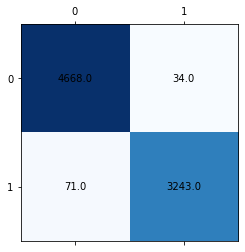

In [12]:
if __name__ == "__main__":
        a=BoWsvm()
        c=a.accuracy()
        print(c)
        print((c[0,0]+c[1,1])/(c[0,0]+c[1,1]+c[0,1]+c[1,0]))
#     logistic_classification()
#     bert=0.86245493
#     svm=2.25609201
#     length=-0.08396549
#     max_w=[]
#     bn=0
#     sn=0
#     ln=0
#     with open('test_modified.csv','r') as csvfile:
#         reader = csv.reader(csvfile)
#         for i,rows in enumerate(reader):
#             if i > 0:
#                 w1=abs(bert*float(rows[0]))
#                 w2=abs(svm*float(rows[1]))
#                 w3=abs(length*float(rows[2]))
#                 x=max(w1, w2, w3)
#                 if(x==w1):
#                     bn+=1
#                     max_w.append("bert")
#                 if(x==w2):
#                     sn+=1
#                     max_w.append("svm")
#                 if(x==w3):
#                     ln+=1
#                     max_w.append("length")
#     print("number of news mainly predicted based on BERT, SVM, Length")
#     print(bn, sn, ln)


#     a=moreFeature()
#     a.most_significant_terms()


#     myLSTM()


#     a = word2VecRNN()
#     a.train(0.00007)

